# The Travelling Salesman Problem (TSP)

## Librerías

In [115]:
import os
import sys
import math
from matplotlib import pyplot as plt
import numpy as np

import random

## Leer archivo

In [113]:
def leer_fichero(file_path):
    
    # Lista para guardar las posiciones
    positions = []
    if not os.path.isfile(file_path):
        print("ERROR - no se ha encontrado el fichero")
        sys.exit()

    with open(file_path, "r") as file:
        for line in file:
            if line is not None:
                if line[0].isdigit():

                    line = line.strip()
                    line_elements = line.split()
                    positions.append((float(line_elements[1]), float(line_elements[2])))

    # Extrae el fichero
    file_name = os.path.basename(file_path)

    return positions, file_name

## Calcular la matriz de pesos

In [3]:
def get_distances(positions:list):
    distances = np.zeros((len(positions),len(positions)))
    npuntos = len(positions)
    for i in range(npuntos):
        for j in range(npuntos):
            if positions[j][0]==positions[i][0] and positions[j][1] == positions[i][1]:
                aux = np.inf
            else:
                aux = math.sqrt(math.pow((positions[j][0]-positions[i][0]),2)+math.pow((positions[j][1]-positions[i][1]),2))
            distances[i][j] = aux
    return distances

## Pintar resultado

In [85]:
def pintar(positions,path):
    for position in positions:
        plt.plot(position[0],position[1], marker="o", color="red")
    x = []
    y = []
    for i in path:
        position = positions[i]
        x.append(position[0])
        y.append(position[1])
    
    plt.plot(x,y,linestyle='solid',color='green')
    plt.show()
    

# Ant colony optimization algorithm

In [5]:
class Grafo(object):
    def __init__(self, distances: list, num_hormigas, alpha, beta,Q):
        self.distances = distances
        self.npuntos = len(distances)
        self.visitados = []
        self.permitidos = [i for i in range(0,self.npuntos)]
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        
        # Inicializamos el grafo con un nodo aleatorio
        inicial = random.randint(0,self.npuntos-1)
        # Añadimos el nodo inicial a la lista de visitados
        self.visitados.append(inicial)
        # Ponemos el puntero del nodo actual en el nodo inicial
        self.actual = inicial
        # Eliminamos el nodo inicial de la lista de permitidos
        self.permitidos.remove(inicial)
        # Inicializamos la distancia total a 0
        self.distancia_total = 0

        # Calculamos el camino escogiendo aquel camino que sea el más corto
        while len(self.permitidos) != 0:
            minimo = np.inf
            siguiente = -1
            for i in self.permitidos:
                if self.distances[self.actual][i]<minimo:
                    minimo = self.distances[self.actual][i]
                    siguiente = i
            self.permitidos.remove(siguiente)
            self.visitados.append(siguiente)
            self.distancia_total += minimo
            self.actual = siguiente

        # Añadimos de nuevo el nodo inicial para cerrar el camino
        self.visitados.append(inicial)
        self.distancia_total += self.distances[self.actual][inicial]

        # Inicializamos las feromonas como (num_hormigas*Q)/(npuntos * distancia_camino_minimo)
        self.feromonas = [[(num_hormigas*self.Q)/(self.npuntos*self.distancia_total) for i in range(self.npuntos)] for j in range(self.npuntos)] 


In [6]:
class Colonia(object):
    def __init__(self,num_hormigas,iteraciones,rho):
        self.num_hormigas = num_hormigas
        self.iteraciones = iteraciones
        self.rho = rho
        
    # Actualiza las feromonas
    # τxy = (1-ρ)τxy + ΣΔτxy
    def actualiza_feromonas(self, grafo:Grafo, hormigas: list):
        for i, fila in enumerate(grafo.feromonas):
            for j, columna in enumerate(fila):
                grafo.feromonas[i][j] *= 1-self.rho
                for hormiga in hormigas:
                    grafo.feromonas[i][j] += hormiga.feromonas[i][j]
    
    def resolver(self,grafo:Grafo):
        minimo = np.inf
        solucion = []
        for i in range(self.iteraciones):
            hormigas = [Hormiga(self,grafo) for id_hormiga in range(self.num_hormigas)]
            for hormiga in hormigas:
                for nodo in range(grafo.npuntos - 1):
                    hormiga.selecciona_nodo()
                
                hormiga.distancia_total += grafo.distances[hormiga.visitados[-1]][hormiga.visitados[0]]
                hormiga.visitados.append(hormiga.visitados[0])
                if hormiga.distancia_total < minimo:
                    minimo = hormiga.distancia_total
                    solucion = hormiga.visitados
              
                # Calcula las delta_feromonas (Δτxy) para el cálculo que realizaremos a continuación
                hormiga.delta_feromonas()
                
            # Una vez que la hormiga llega a su destino, se debe actualizar las feromonas de cada camino 
            # respecto al desgaste o evaporación ρ y si pasó la hormiga por el camino dejando feromonas.
            self.actualiza_feromonas(grafo,hormigas)
            
        return solucion, minimo

In [110]:
class Hormiga(object):
    def __init__(self, colonia: Colonia, grafo: Grafo):
        #self.colonia = colonia # colonia
        self.grafo = grafo
        self.distancia_total = 0.0
        self.visitados = []
        self.feromonas = []
        self.permitidos = [i for i in range(grafo.npuntos)]
        
        # Situamos a la hormiga en un nodo aleatorio del grafo
        inicio = random.randint(0, grafo.npuntos - 1)
        # Añadimos el nodo a la lista de visitados por la hormiga
        self.visitados.append(inicio)
        # Situamos el puntero del nodo actual en el nodo de inicio
        self.actual = inicio
        # Eliminamo el nodo inicial de la lista de permitidos
        self.permitidos.remove(inicio)
    
    # Selecciona un nodo
    # Para calcular el posible camino a tomar de una hormiga, se utiliza la Ecuación:
    # Pxy = (τ(e)*N(e))/(Στ(e)*N(e)), donde τ(e) son las feromonas depositadas por ese
    # camino (A a B), N(e) es la visibilidad del camino dado por N(e) = 1/peso_del_camino,
    # y el denominador de esta ecuación siendo la suma del cálculo anterior (τ(e)*N(e)) de
    # todos los posibles que tiene esa hormiga
    def selecciona_nodo(self):
        N = 1/self.grafo.distances
        numerador = []
        denominador = 0
        for i in self.permitidos:
            aux = (self.grafo.feromonas[self.actual][i]**self.grafo.alpha)*(N[self.actual][i]**self.grafo.beta)
            denominador += aux
            numerador.append(aux)
        P = numerador/denominador
        peso_minimo = -1
        nodo_minimo = -1
        for i,p in enumerate(P):
            if p>peso_minimo:
                peso_minimo = p
                nodo_minimo = self.permitidos[i]
        
        self.permitidos.remove(nodo_minimo)
        self.visitados.append(nodo_minimo)
        self.distancia_total += self.grafo.distances[self.actual][nodo_minimo]
        self.actual = nodo_minimo
    
    # Calcula las Δτxy como Q/Lk si se usó xy ó 0 en caso contrario
    def delta_feromonas(self):
        self.feromonas = [[0 for j in range(self.grafo.npuntos)] for i in range(self.grafo.npuntos)]
        for i in range(0,len(self.visitados)-1):
            nodo = self.visitados[i]
            siguiente = self.visitados[i+1]
            # Q es el parámetro de aprendizaje y Lk (distancia total) es el costo del camino por hormiga
            self.feromonas[nodo][siguiente] = self.grafo.Q/self.distancia_total

# Ejecución

## Leemos el archivo y lo mostramos

In [8]:
positions, fname = leer_fichero("./wi29.tsp")

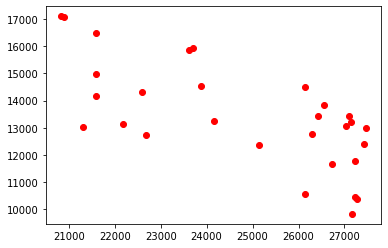

In [9]:
for position in positions:
    plt.plot(position[0],position[1], marker="o", color="red")
plt.show()

## Calculamos la matriz de distancias:

In [10]:
distances = get_distances(positions)

## Definimos los Parámetros:

In [11]:
# Parámetros
num_hormigas = [5, 10, 20]
iteraciones = 625
rho = [0.15, 0.25, 0.5]
q = [0.3, 0.6, 0.9]
alpha = [0.05, 0.1, 0.35]
beta = [0.5, 1, 2]

## Buscamos el camino más corto

In [12]:
def buscar(d,m,r,q,a,b):

    colonia = Colonia(m,iteraciones,r)
    grafo = Grafo(d,m,a,b,Q)
    camino,longitud = colonia.resolver(grafo)
    return camino,longitud

### Debido al warning RunTime, se ha optado por ejecutar el programa poco a poco para diferentes parámetros

In [59]:
caminos1 = []
longitudes1 = []
for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[0]
        b = beta[0]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos1.append(camino)
        longitudes1.append(longitud)

In [14]:
caminos2 = []
longitudes2 = []
for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[0]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos2.append(camino)
        longitudes2.append(longitud)

In [15]:
caminos3 = []
longitudes3 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[0]
        b = beta[2]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos3.append(camino)
        longitudes3.append(longitud)

In [16]:
caminos4 = []
longitudes4 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[1]
        b = beta[0]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos4.append(camino)
        longitudes4.append(longitud)

In [17]:
caminos5 = []
longitudes5 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[1]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos5.append(camino)
        longitudes5.append(longitud)

In [18]:
caminos6 = []
longitudes6 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[1]
        b = beta[2]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos6.append(camino)
        longitudes6.append(longitud)

In [19]:
caminos7 = []
longitudes7 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[2]
        b = beta[0]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos7.append(camino)
        longitudes7.append(longitud)

In [20]:
caminos8 = []
longitudes8 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[2]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos8.append(camino)
        longitudes8.append(longitud)

In [21]:
caminos9 = []
longitudes9 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[0]
        b = beta[0]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos9.append(camino)
        longitudes9.append(longitud)

In [22]:
caminos10 = []
longitudes10 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[0]
        Q = q[2]
        b = beta[2]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos10.append(camino)
        longitudes10.append(longitud)

In [23]:
caminos11 = []
longitudes11 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[1]
        Q = q[0]
        b = beta[0]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos11.append(camino)
        longitudes11.append(longitud)

In [24]:
caminos12 = []
longitudes12 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[1]
        Q = q[0]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos12.append(camino)
        longitudes12.append(longitud)

In [25]:
caminos13 = []
longitudes13 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[1]
        Q = q[0]
        b = beta[2]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos13.append(camino)
        longitudes13.append(longitud)

In [26]:
caminos14 = []
longitudes14 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[1]
        Q = q[1]
        b = beta[0]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos14.append(camino)
        longitudes14.append(longitud)

In [27]:
caminos15 = []
longitudes15 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[1]
        Q = q[1]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos15.append(camino)
        longitudes15.append(longitud)

In [28]:
caminos16 = []
longitudes16 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[1]
        Q = q[1]
        b = beta[2]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos16.append(camino)
        longitudes16.append(longitud)

In [29]:
caminos17 = []
longitudes17 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[1]
        Q = q[2]
        b = beta[0]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos17.append(camino)
        longitudes17.append(longitud)

In [30]:
caminos18 = []
longitudes18 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[1]
        Q = q[2]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos18.append(camino)
        longitudes18.append(longitud)

In [31]:
caminos19 = []
longitudes19 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[1]
        Q = q[2]
        b = beta[2]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos19.append(camino)
        longitudes19.append(longitud) 

In [32]:
caminos20 = []
longitudes20 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[2]
        Q = q[0]
        b = beta[0]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos20.append(camino)
        longitudes20.append(longitud)

In [33]:
caminos21 = []
longitudes21 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[2]
        Q = q[0]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos21.append(camino)
        longitudes21.append(longitud)

In [34]:
caminos22 = []
longitudes22 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[2]
        Q = q[0]
        b = beta[2]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos22.append(camino)
        longitudes22.append(longitud)

In [35]:
caminos23 = []
longitudes23 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[2]
        Q = q[1]
        b = beta[0]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos23.append(camino)
        longitudes23.append(longitud)

In [36]:
caminos24 = []
longitudes24 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[2]
        Q = q[1]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos24.append(camino)
        longitudes24.append(longitud)

In [37]:
caminos25 = []
longitudes25 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[2]
        Q = q[1]
        b = beta[2]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos25.append(camino)
        longitudes25.append(longitud)

In [38]:
caminos26 = []
longitudes26 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[2]
        Q = q[2]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos26.append(camino)
        longitudes26.append(longitud)

In [39]:
caminos27 = []
longitudes27 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[2]
        Q = q[2]
        b = beta[1]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos27.append(camino)
        longitudes27.append(longitud)

In [40]:
caminos28 = []
longitudes28 = []

for m in num_hormigas:
    for r in rho:
        a = alpha[2]
        Q = q[2]
        b = beta[2]
        d = distances.copy()
        camino,longitud = buscar(d,m,r,Q,a,b)
        caminos28.append(camino)
        longitudes28.append(longitud)

### Juntamos todos los caminos y longitudes en una sola lista

In [69]:
caminos = caminos1[:]
longitudes = longitudes1[:]
caminos.extend(caminos2)
caminos.extend(caminos3)
caminos.extend(caminos4)
caminos.extend(caminos5)
caminos.extend(caminos6)
caminos.extend(caminos7)
caminos.extend(caminos8)
caminos.extend(caminos9)
caminos.extend(caminos10)
caminos.extend(caminos11)
caminos.extend(caminos12)
caminos.extend(caminos13)
caminos.extend(caminos14)
caminos.extend(caminos15)
caminos.extend(caminos16)
caminos.extend(caminos17)
caminos.extend(caminos18)
caminos.extend(caminos19)
caminos.extend(caminos20)
caminos.extend(caminos21)
caminos.extend(caminos22)
caminos.extend(caminos23)
caminos.extend(caminos24)
caminos.extend(caminos25)
caminos.extend(caminos26)
caminos.extend(caminos27)
caminos.extend(caminos28)
longitudes.extend(longitudes2)
longitudes.extend(longitudes3)
longitudes.extend(longitudes4)
longitudes.extend(longitudes5)
longitudes.extend(longitudes6)
longitudes.extend(longitudes7)
longitudes.extend(longitudes8)
longitudes.extend(longitudes9)
longitudes.extend(longitudes10)
longitudes.extend(longitudes11)
longitudes.extend(longitudes12)
longitudes.extend(longitudes13)
longitudes.extend(longitudes14)
longitudes.extend(longitudes15)
longitudes.extend(longitudes16)
longitudes.extend(longitudes17)
longitudes.extend(longitudes18)
longitudes.extend(longitudes19)
longitudes.extend(longitudes20)
longitudes.extend(longitudes21)
longitudes.extend(longitudes22)
longitudes.extend(longitudes23)
longitudes.extend(longitudes24)
longitudes.extend(longitudes25)
longitudes.extend(longitudes26)
longitudes.extend(longitudes27)
longitudes.extend(longitudes28)
print(caminos)
print(longitudes)

[[0, 1, 5, 4, 3, 7, 6, 8, 2, 12, 13, 16, 17, 18, 21, 22, 20, 28, 27, 25, 19, 15, 24, 26, 23, 14, 11, 9, 10, 0], [7, 3, 4, 5, 1, 0, 9, 10, 11, 12, 13, 16, 17, 18, 14, 21, 22, 20, 28, 27, 25, 19, 15, 24, 26, 23, 8, 6, 2, 7], [7, 3, 4, 5, 1, 0, 10, 9, 11, 12, 13, 16, 17, 18, 14, 21, 22, 20, 28, 27, 25, 19, 15, 24, 26, 23, 8, 6, 2, 7], [4, 3, 7, 6, 8, 2, 12, 13, 16, 17, 18, 21, 22, 20, 28, 27, 25, 19, 15, 24, 26, 23, 14, 11, 9, 10, 5, 1, 0, 4], [10, 9, 11, 7, 3, 4, 5, 1, 0, 2, 6, 8, 12, 13, 16, 17, 18, 21, 22, 20, 28, 27, 25, 19, 15, 24, 26, 23, 14, 10], [7, 3, 4, 5, 1, 0, 9, 10, 11, 12, 13, 16, 17, 18, 14, 21, 22, 20, 28, 27, 25, 19, 15, 24, 26, 23, 8, 6, 2, 7], [7, 3, 4, 5, 1, 0, 9, 10, 11, 12, 13, 16, 17, 18, 14, 21, 22, 20, 28, 27, 25, 19, 15, 24, 26, 23, 8, 6, 2, 7], [7, 3, 4, 5, 1, 0, 9, 10, 11, 12, 13, 16, 17, 18, 14, 21, 22, 20, 28, 27, 25, 19, 15, 24, 26, 23, 8, 6, 2, 7], [7, 3, 4, 5, 1, 0, 9, 10, 11, 12, 13, 16, 17, 18, 14, 21, 22, 20, 28, 27, 25, 19, 15, 24, 26, 23, 8, 6, 2, 7],

In [88]:
i_min = []
for i,l in enumerate(longitudes):
    if len(i_min)<6:
        i_min.append(i)
    else:
        maximo = longitudes[i_min[0]]
        pos = 0
        for j in range(1,6):
            if longitudes[i_min[j]]>maximo:
                maximo = longitudes[i_min[j]]
                pos = j
              
        
        if l<maximo:
            i_min[pos]= i

### Obtenemos las posiciones de los caminos más cortos y los pintamos

In [89]:
i_min

[37, 55, 113, 211, 200, 229]

In [104]:
infos = []
for m in num_hormigas:
    for r in rho:
        for a in alpha:
            for Q in q:
                for b in beta:
                    info =[m,r,a,Q,b]
                    infos.append(info)

29881.981999188767
[5, 0.25, 0.1, 0.3, 1]


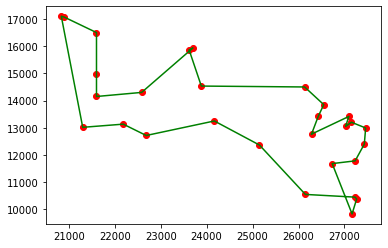

29863.25398663174
[5, 0.5, 0.05, 0.3, 1]


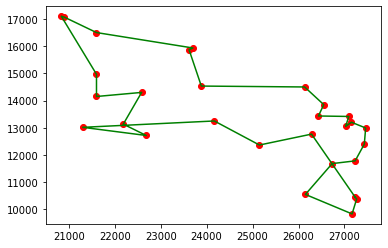

29759.858615278194
[10, 0.25, 0.05, 0.6, 2]


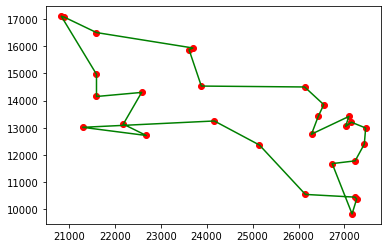

29469.080386194644
[20, 0.25, 0.35, 0.6, 1]


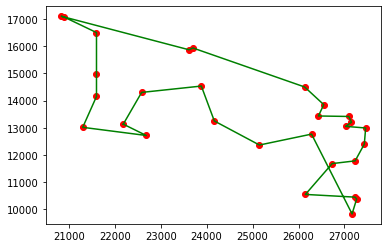

29954.985818037243
[20, 0.25, 0.1, 0.3, 2]


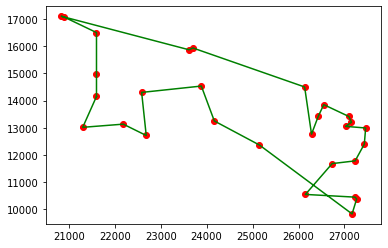

29901.441524353922
[20, 0.5, 0.1, 0.6, 1]


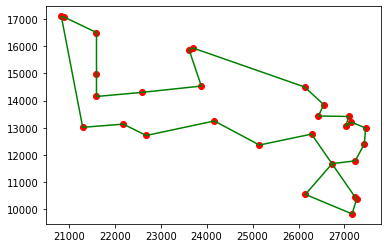

In [105]:
for i in i_min:
    print(longitudes[i])
    print(infos[i])
    pintar(positions,caminos[i])